#  Photon-to-Axion Conversion in a Galactic Halo  
### Constant Magnetic Field, Battaglia Profile, and WKB Approximation. Reduced version where only the WKB cut solution is computed.  
*Author: Salvatore Samuele Sirletti* 


This is a reduced version of the code where only the WKB cut solution is computed. For more information, see the complete notebook. 

The master equation to solve is


$$ u''(z) +\left[1+\left(\frac{\Phi'(z)}{2}\right)^2 - \frac{i}{2}\Phi''(z) \right] u(z) = 0 .$$

Using the master equation in $u$, we are able to compute, far from the resonance points, the WKB solution: 

$$ u_{\rm WKB}(z) = \frac{C_+ e^{i\int \sqrt{1+\left(\frac{\Phi'(z)}{2}\right)^2 - \frac{i}{2}\Phi''(z) } \, dz } + C_- e^{-i\int \sqrt{1+\left(\frac{\Phi'(z)}{2}\right)^2 - \frac{i}{2}\Phi''(z) } \, dz }}{ \left[ \left(1+\frac{\Phi'^2}{4}\right) + \frac{\Phi''^2}{4} \right]^{1/8}} = \frac{C_+ e^{i \Xi(z)} + C_- e^{-i\Xi(z)}}{\sqrt{|\Omega(z)|}}. $$

The derivative of $u_{\rm WKB}$ is 

$$ u'_{\rm WKB}(z) = A_+(z) C_+ e^{i\Xi(z)} + A_-(z) C_- e^{-i\Xi(z)}, $$
where
$$ A_\pm(z) = -\frac{1}{2}\frac{\Re[\Omega(z)] \Re[\Omega'(z)] +\Im[\Omega(z)] \Im[\Omega'(z)]}{|\Omega(z)|^{5/2}}\pm \frac{i \Omega(z)}{|\Omega(z)|^{1/2}}. $$


 The WKB solution is implemented on the intervals z_grid between the points of resonance.

 We search for $C_\pm$ by imposing $\Xi(z_i^{\rm max}) = 0$ and then solving the following system:

$$     \begin{cases}
        u_{\rm numeric} (z_i^{\rm max}) = \frac{C_+ + C_-}{\sqrt{|\Omega(z_i^{\rm max})|}} \\
        u'_{\rm numeric} (z_i^{\rm max}) =C_+ A_+(z_i^{\rm max}) + C_- A_-(z_i^{\rm max})
    \end{cases} \ .$$

$u_{\rm numeric} (z_i^{\rm max})$ and $u_{\rm numeric} (z_i^{\rm max})$ at each $I_i$ are found from the numerical solution implemented with WKB. 




In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import root_scalar
from scipy.integrate import simpson 
from scipy.interpolate import UnivariateSpline

import math
import astropy.units as u
import astropy.constants as const

from numba import njit #Numba to accelerate the code, solving Just in Time


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D




In [2]:
import time

start = time.time()

 <a id="2"></a>

In [3]:
#Want to study photon-to-axion or photon-to-dark-photon?

dark_photon = False #Set False if you want to work with axion

In [4]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


 <a id="3"></a>

In [5]:
########################################
# Specify parameters of the model
########################################

m_a   = 3e-13 * eV# Axion mass in eV
g_agg = 1e-10 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz

if dark_photon:
    eps   = 1e-5 #photon-dark photon coupling “natural” values in the range 1e-13 - 10e-2  



Here insert a good explanation of the trajectory inside the halo. 



In [6]:
########################################
# Specify the halo model: Battaglia's profile 
########################################

rvir  = 2
r_thr = np.logspace(-3, np.log10(rvir), 100000) # radius in Mpc

# Set some parameters (similar to Planck best-fit cosmo)
Omega_b = 0.049
Omega_m = 0.3175
h = 0.6711
H0 = 100*h*u.km/u.s/u.Mpc

z = 0 # redshift
rho_critz = (3*H0**2/(8*np.pi*const.G)).to(u.Msun/u.Mpc**3).value # Msun/Mpc^3


# Halo settings
M200c = 10**13.5 # Msun
R200c = 2 # Mpc





def get_ne_battaglia(r, M200c, R200c, z, rho_critz, Omega_b, Omega_m,
                     param_dict=None):
       """
       Computes Battaglia profile as a function of radius. 

       Parameters:
           r: Radius in Mpc
           M200c: M200c in Msun
           R200c: R200c in Mpc
           z: Redshift
           rho_crit_z: Critical density in Msun/Mpc^3
           param_dict: Optional parameters for profile

       Returns:
           Electron number density profile in (1/Mpc**3)

       """

       # Unit conversion
       m_p = 8.411856872862986e-58 # Proton mass in units of Msun
       if param_dict is None:
           # Get Battaglia profile parameters at appropriate redshift
           rho0  = 4000. * (M200c/1e14)**0.29    * (1.+z)**(-0.66)
           alpha = 0.88  * (M200c/1e14)**(-0.03) * (1.+z)**0.19
           beta  = 3.83  * (M200c/1e14)**0.04    * (1.+z)**(-0.025)
           gamma = -0.2

       else:
           rho0  = param_dict['rho0']
           alpha = param_dict['alpha']
           beta  = param_dict['beta']
           gamma = param_dict['gamma']

       x = 2*r/R200c    
       fb = Omega_b/Omega_m
    
       rho_gas = fb*rho_critz*rho0 * (x**gamma) * ((1.+x**alpha)**(-(beta+gamma)/alpha))
       ne_prof = (1+0.76)/(2*m_p)*rho_gas 

       return ne_prof


# Compute profile in M_sun/Mpc**3
n_er = get_ne_battaglia(r_thr, M200c, R200c, z, rho_critz, Omega_b, Omega_m)

#Converting to 1/cm^3 and then to eV^3:
n_er_not_int = (n_er/u.Mpc**3).to(1/u.cm**3).value * numerical_density #first conversion units with astropy
#n_er_not_int = n_er_not_int * (1+0.3*np.sin(75*np.log(r_thr)) *r_thr) 
#n_er_not_int = n_er_not_int * (1+0.2*np.sin(75*np.log(r_thr)) *r_thr) 


#Interpolating ne
n_er_interp = interp1d(r_thr, n_er_not_int, kind='cubic', bounds_error=False, fill_value="extrapolate") 


In [7]:
######################################################
# Specify functions Delta_a and Delta_parallel wrt r
######################################################

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_ar(r):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

def m2_gr(r):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_er_interp(r) #in eV units 


def Delta_parallelr(r):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_gr(r) /(2* omega)


In [8]:
#########################
# Searching for r_res
#########################

def resonance_condition(r):
    return Delta_parallelr(r) - Delta_ar(r)

# Is there a resonance point?
signs = np.sign(resonance_condition(r_thr))
sign_change_indices = np.where(np.diff(signs))[0]
if len(sign_change_indices) == 0:
    raise RuntimeError("No sign change found: resonance does not occur in this interval.")

#Using the Brent's method to find the root in the interval where the sign changes
i = sign_change_indices[0]
r_low, r_high = r_thr[i], r_thr[i+1]
r_res = brentq(resonance_condition, r_low, r_high)

print(f"Resonance radius found: r_res = {r_res} Mpc")

Resonance radius found: r_res = 1.4521732239327674 Mpc


In [9]:
##################################################################
# Defining uniquely the trajectory, it must be higher than r_res 
##################################################################

rmin  = 1.435

# Geometry of the photon path through the halo
chord_length = 2*np.sqrt(rvir**2 - rmin**2) # Length of the chord crossing the halo (in Mpc)
phii  = np.arcsin(rmin / rvir)  # Impact angle of the trajectory from center (in radians)

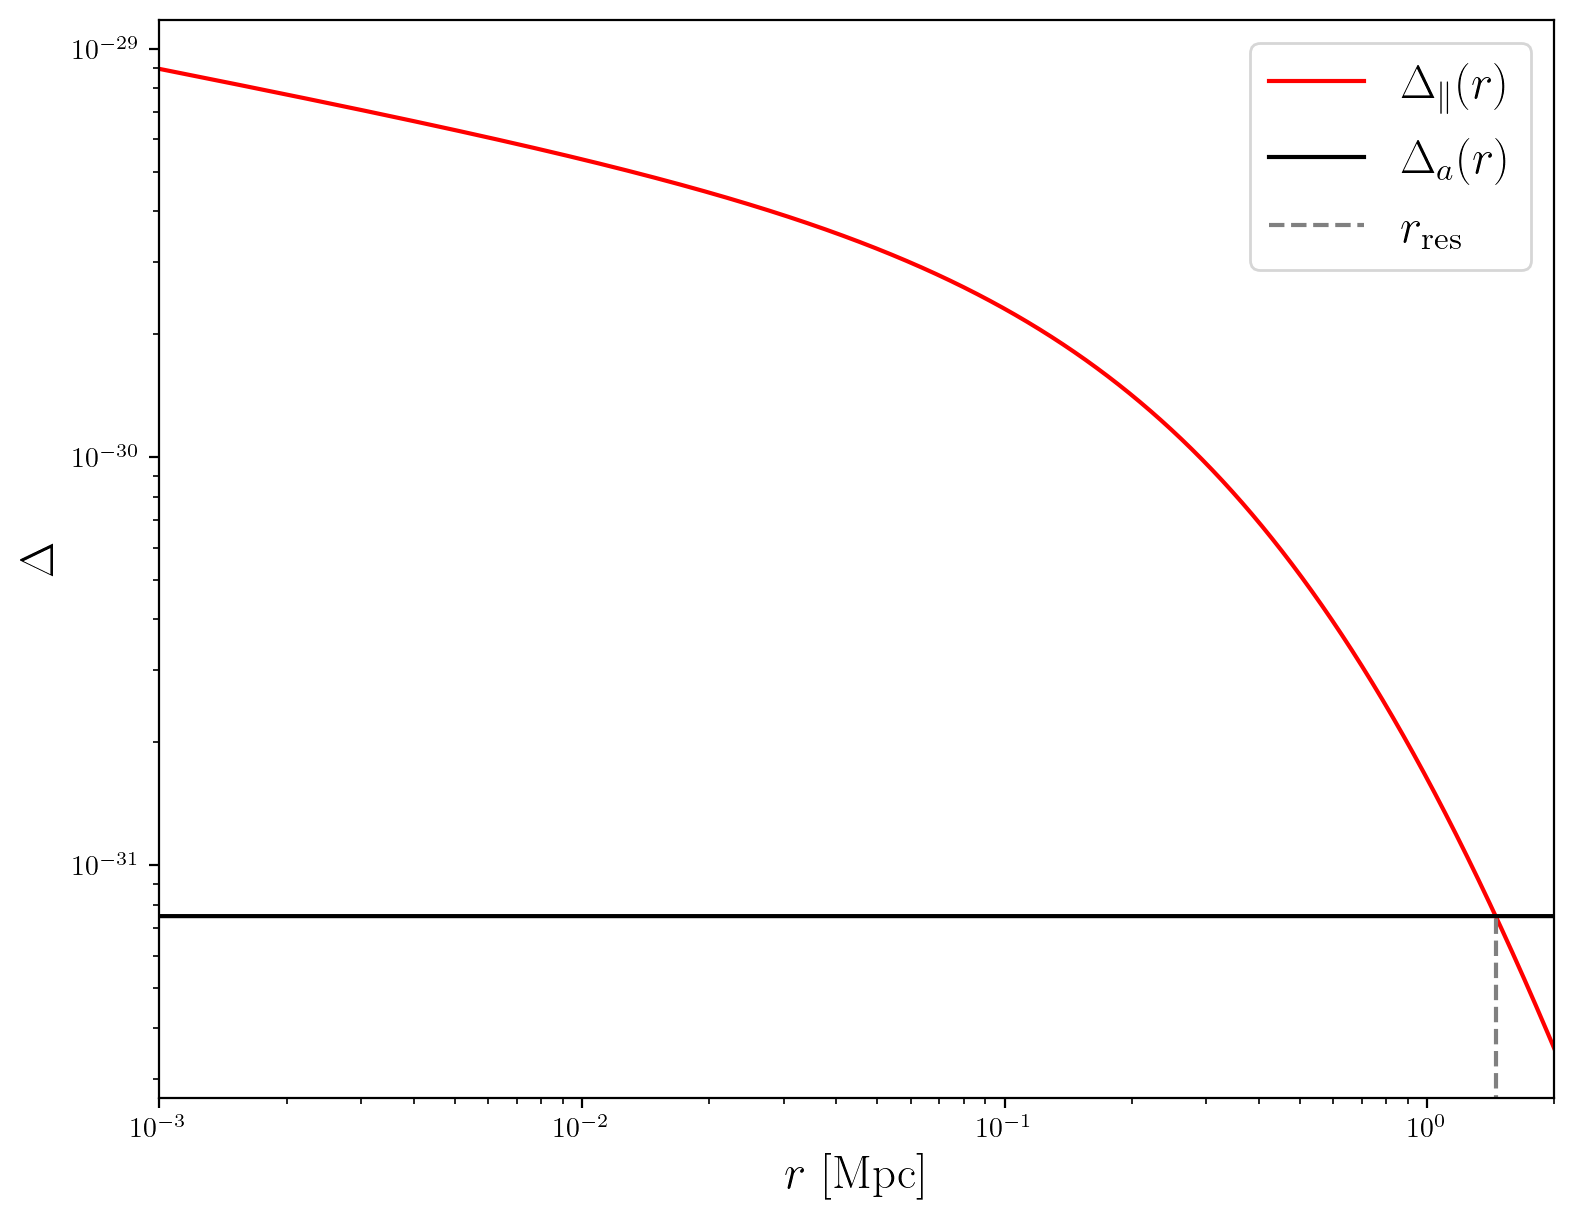

In [10]:
# Delta_parallel(r) vs Delta_a(r)


plt.plot(r_thr, Delta_parallelr(r_thr), color='r' , label = r'$\Delta_\parallel(r)$')
plt.plot(r_thr, Delta_ar(r_thr)*np.ones_like(r_thr), color='k',  label = r'$\Delta_a(r)$')
r_res_line = plt.vlines(r_res, 0, Delta_ar(r_res), linestyle='dashed', color='gray', label=r'$r_{\rm res}$')
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, 2)
plt.xlabel(r"$r~[{\rm Mpc}]$", fontsize=17)
plt.ylabel(r"$\Delta$", fontsize=17)
plt.legend(fontsize=17)
plt.show()

In [11]:
########################################
# Mapping the halo model on the chord and setting the interval of integration
########################################

# Integration steps
z_num      = 5_000_001
z_num_half = (z_num + 1) // 2  # To ensure symmetry

# Define radial trajectory: from r_vir → r_min → r_vir (chord)
r_vals_1 = np.linspace(rvir, rmin, z_num_half)
r_vals_2 = np.linspace(rmin, rvir, z_num_half)
r_vals_on_trj = np.concatenate([r_vals_1, r_vals_2[1:]])  # Avoid duplicated rmin

# Projected distance along the chord
z_chord = np.sqrt(r_vals_on_trj**2 - rmin**2)

# Define the integration coordinate z_thr in Mpc (centered around 0)
z_thr = np.empty_like(z_chord) 
z_thr[:z_num_half]  = -z_chord[:z_num_half] + chord_length / 2 
z_thr[z_num_half:]  =  z_chord[z_num_half:] + chord_length / 2


# Optional: reference scale z_0 ≈ 1 Mpc (used in rescaling)
z_0 = z_thr[np.argmin(np.abs(z_thr - 1))]

# Associate n_e(r) along the trajectory, convert to eV³
ne_values_chord = n_er_interp(r_vals_on_trj)

# Prepare values for numba-interpolated function n_e(z)
z_vals = z_thr.copy()
ne_vals = ne_values_chord.copy()

@njit
def n_e(z, z_vals, ne_vals):
    return np.interp(z, z_vals, ne_vals)

In [12]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

def Delta_a(z):
    """
    Axion mass term 
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 

Delta_a_value =  m_a**2/(2*omega) 
Delta_a_vals = np.array([Delta_a(z) for z in z_thr])


@njit
def m2_g(z, z_vals, ne_vals):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return ElementaryCharge**2 / mass_electron * n_e(z, z_vals, ne_vals)

m2_g_vals = np.array([m2_g(z, z_vals, ne_vals) for z in z_thr])


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 


@njit
def Delta_parallel(z, z_vals, ne_vals):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z, z_vals, ne_vals) / (2 * omega)

Delta_parallel_vals = np.array([Delta_parallel(z, z_vals, ne_vals) for z in z_thr])


if dark_photon:
    def Delta_ag(z):
        return eps*Delta_a(z)
else:
    def Delta_ag(z):
        """
        Axion-photon coupling term
        Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
        """
        return g_agg/2 * B_T(z)
    
Delta_ag_value = Delta_ag(0)
Delta_ag_vals =  np.array([Delta_ag(z) for z in z_thr])

@njit
def Delta_diff(z, z_vals, ne_vals, Delta_a_val):
    """
    Difference between Delta_parallel and Delta_a
    """
    return Delta_parallel(z, z_vals, ne_vals) - Delta_a_val

Delta_diff_vals = np.array([Delta_diff(z, z_vals, ne_vals, Delta_a_value) for z in z_thr])


In [13]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

#Searching where Delta_diff changes sign
sign_changes = np.where(np.diff(np.sign(Delta_diff_vals)) != 0)[0]

# Searchinf for all the roots of Delta_diff
z_resonances = []

for i in sign_changes:
    z_left = z_thr[i]
    z_right = z_thr[i + 1]
    
    try:
        sol = root_scalar(Delta_diff, bracket=[z_left, z_right], args=(z_vals, ne_vals, Delta_a_value), method='brentq')
        if sol.converged:
            z_resonances.append(sol.root)
    except ValueError:
        continue

z_resonances = np.array(z_resonances)

# Index of the resonance points
index_resonances = [np.argmin(np.abs(z_thr - z_res)) for z_res in z_resonances]


In [14]:
z_resonances

array([1.17044669, 1.61578733])

In [15]:
########################################
# Computing the derivative of Delta_parallel and the gamma factor
########################################

# Numerical derivative of Delta_parallel with respect to z (in Mpc)
dDelta_parallel = np.abs(np.gradient(Delta_parallel_vals, z_thr)) / Mpc

# Gamma(z) = Delta_ag^2 / |dDelta_parallel/dz|
gamma_factor = (Delta_ag_value)**2 / dDelta_parallel

# Print gamma at each resonance point
print('--- Gamma factor at each resonance point ---')
for i, idx in enumerate(index_resonances):
    print(f"Gamma at resonance {i+1}: {gamma_factor[idx]}")

--- Gamma factor at each resonance point ---
Gamma at resonance 1: 0.008453423624145147
Gamma at resonance 2: 0.008453423624145147


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_38273/2026938536.py:9: RuntimeWarning: divide by zero encountered in divide
  gamma_factor = (Delta_ag_value)**2 / dDelta_parallel


--- Resonance positions in \tilde{z} ---
tilde_z_res[1] = 178.48141525625542
tilde_z_res[2] = 246.3914100648163


/opt/miniconda3/envs/cosmo_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


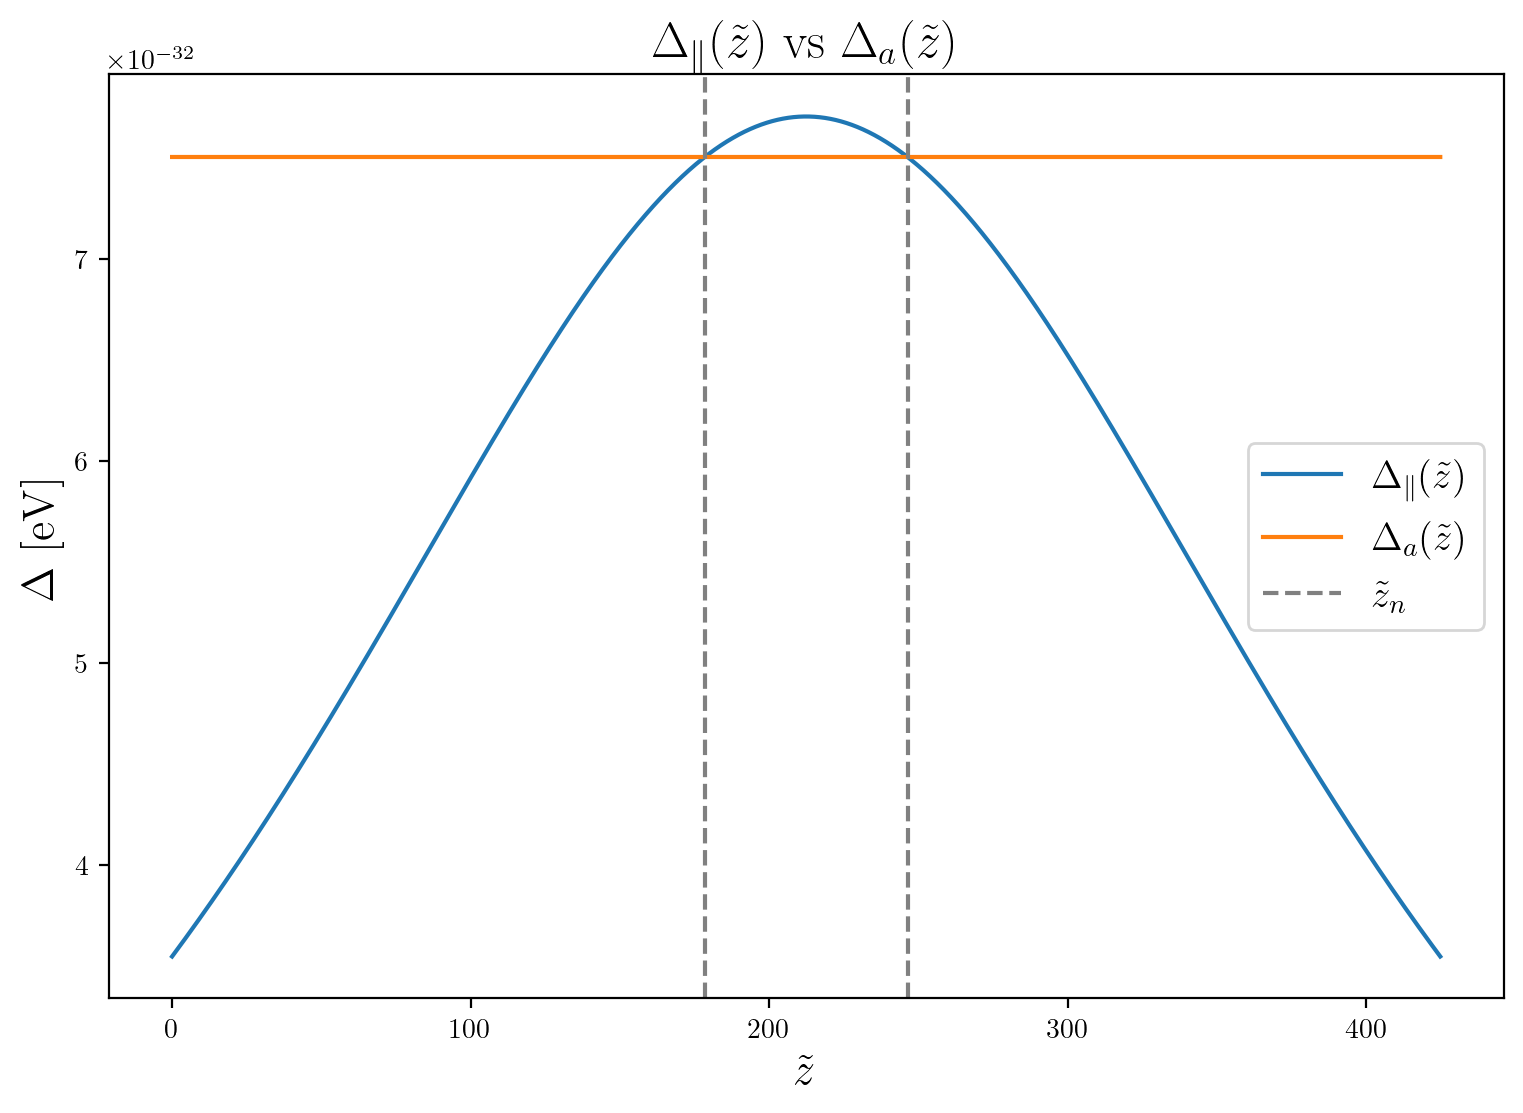

In [16]:
########################################
# Conversion from z_thr in Mpc to \tilde{z}, 
# because both the Battaglia profile and the mapping were computed in units of Mpc
########################################

# Define \tilde{z}
z_tilde_thr = Delta_ag_vals * Mpc * z_thr

# Compute Delta_parallel(\tilde{z})
@njit
def Delta_parallel_tilde(zt, Delta_ag_val, z_vals, ne_vals):
    z_phys = zt / (Delta_ag_val * Mpc)
    return Delta_parallel(z_phys, z_vals, ne_vals)

Delta_parallel_tilde_vals = np.array([
    Delta_parallel_tilde(z, Delta_ag_value, z_vals, ne_vals) 
    for z in z_tilde_thr
])

# Convert all resonance points to \tilde{z}
z_tilde_resonances = Delta_ag_value * Mpc * z_resonances

# Print converted values
print("--- Resonance positions in \\tilde{z} ---")
for i, zt_res in enumerate(z_tilde_resonances):
    print(f"tilde_z_res[{i+1}] = {zt_res}")

# Plot Delta_parallel(\tilde{z}) and Delta_a(\tilde{z})
plt.figure(figsize=(9, 6))
plt.plot(z_tilde_thr, Delta_parallel_tilde_vals, label=r"$\Delta_\parallel(\tilde{z})$")
plt.plot(z_tilde_thr, Delta_a_vals, label=r"$\Delta_a(\tilde{z})$")

# Vertical lines at each \tilde{z}_res
for i, zt_res in enumerate(z_tilde_resonances):
    plt.axvline(x=zt_res, linestyle='dashed', color='gray', label=r"$\tilde{z}_n$" if i == 0 else None)

plt.xlabel(r"$\tilde{z}$", fontsize=16)
plt.ylabel(r"$\Delta~[\mathrm{eV}]$", fontsize=16)
plt.title(r"$\Delta_\parallel(\tilde{z})$ vs $\Delta_a(\tilde{z})$", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [17]:
########################################
# Computing the derivative of Delta_parallel and the gamma factor 
# in units of \tilde{z} = Delta_ag * Mpc * z
########################################

# Numerical derivative with respect to \tilde{z}
dDelta_parallel_tilde = np.abs(np.gradient(Delta_parallel_tilde_vals, z_tilde_thr))

# Gamma(\tilde{z}) = Delta_ag / |d Delta_parallel / d \tilde{z}|
gamma_factor_tilde = Delta_ag_value / dDelta_parallel_tilde

# Print gamma at each resonance point in \tilde{z}
print('--- Gamma factor at each resonance (in \\tilde{z}) ---')
for i, idx in enumerate(index_resonances):
    print(f"Gamma_tilde at resonance {i+1}: {gamma_factor_tilde[idx]}")

--- Gamma factor at each resonance (in \tilde{z}) ---
Gamma_tilde at resonance 1: 0.008453423621931912
Gamma_tilde at resonance 2: 0.008453423625218469


/var/folders/jc/kky54qz15j50ck9_kzrzk_d80000gn/T/ipykernel_38273/2488471004.py:10: RuntimeWarning: divide by zero encountered in divide
  gamma_factor_tilde = Delta_ag_value / dDelta_parallel_tilde


In [18]:
########################################
# Cutting the total interval to reduce the computing time of the solver
########################################

cut = True

# Resonance length: lambda_res = sqrt(2 pi gamma)
R_length_tilde = np.sqrt(2 * np.pi * gamma_factor_tilde)
c = 100  # multiplier for the size of the cut region. This is set to 100 here. 
         #It is possible to change it later. In the case it is too big, it will be automatically adapted when the cut is performed. 

# Define cut boundaries based on the first and last resonances
idx_first = index_resonances[0]
idx_last = index_resonances[-1]

Delta_z_first = c * R_length_tilde[idx_first]
Delta_z_last =  c * R_length_tilde[idx_last]

z_tilde_res_first = z_tilde_resonances[0]
z_tilde_res_last  = z_tilde_resonances[-1]

if cut:
    z_min = z_tilde_res_first - Delta_z_first
    z_max = z_tilde_res_last  + Delta_z_last
    z_tilde_thr_cut = np.linspace(z_min, z_max, 1_000_000)
else:
    z_tilde_thr_cut = z_tilde_thr

# Interpolate Delta_parallel_tilde over the possibly reduced grid
Delta_parallel_tilde_cut_interp = np.interp(z_tilde_thr_cut, z_tilde_thr, Delta_parallel_tilde_vals)

In [19]:
# Here the code finds automatically a good interval width around the points of resonance. 

c = 100  #Here it is possibile to change the multiplier for the size of the cut region chosen above.

while True:
    ########################################
    # Defining N symmetric intervals around each resonance point (no WKB)
    ########################################
    N_grid = 1_000_000 # Number of points per interval
    z_tilde_thr_cut_list = []
    Delta_parallel_tilde_cut_interp_list = []
    for i, idx in enumerate(index_resonances):
        z_res = z_tilde_resonances[i]
        delta_z = c * np.sqrt(2 * np.pi * gamma_factor_tilde[idx])
        z_min = z_res - delta_z
        z_max = z_res + delta_z
        z_cut = np.linspace(z_min, z_max, N_grid)
        z_tilde_thr_cut_list.append(z_cut)
        # Interpolate Delta_parallel_tilde on this subinterval
        Delta_interp = np.interp(z_cut, z_tilde_thr, Delta_parallel_tilde_vals)
        Delta_parallel_tilde_cut_interp_list.append(Delta_interp)

    ########################################
    # Defining N-1 intermediate grids between resonance intervals,
    # to compute the phase and locate the new z_min positions
    ########################################
    z_grid_list = []
    Delta_parallel_grid_list = []
    Delta_parallel_minus_Delta_a_grid_list = []
    Delta_ag_grid_list = []
    for i in range(len(index_resonances) - 1):
        # Endpoint of current interval
        z_right_i = z_tilde_thr_cut_list[i][-1]
        # Start of next interval (tentative left bound)
        idx_next = index_resonances[i+1]
        z_left_next = z_tilde_resonances[i+1] - c * np.sqrt(2 * np.pi * gamma_factor_tilde[idx_next])
        # Grid between intervals
        z_grid = np.linspace(z_right_i, z_left_next, 20_000_000) #In the case of N>2, this value needs to be huge to be as precise as possible. 
                                                                 #for N = 2 this can be 2_000_000 or less.                     
        z_grid_list.append(z_grid)
        # Interpolated quantities over this grid
        Delta_par = np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals)
        Delta_parallel_grid_list.append(Delta_par)
        Delta_diff = Delta_par - Delta_a_value
        Delta_parallel_minus_Delta_a_grid_list.append(Delta_diff)
        Delta_ag = np.interp(z_grid, z_tilde_thr, Delta_ag_vals)
        Delta_ag_grid_list.append(Delta_ag)

    ########################################
    # Computing cumulative phase and oscillation number N for each intermediate region
    ########################################
    phi_cumulative_list = []
    phi_total_list = []
    N_estimate_list = []
    for i in range(len(z_grid_list)):
        phase_integrand = np.abs(Delta_parallel_minus_Delta_a_grid_list[i]) / Delta_ag_grid_list[i]
        phi_cumulative = cumulative_trapezoid(phase_integrand, z_grid_list[i], initial=0)
        phi_total = phi_cumulative[-1]
        N_estimate = int(np.floor(phi_total / (2 * np.pi)))
        phi_cumulative_list.append(phi_cumulative)
        phi_total_list.append(phi_total)
        N_estimate_list.append(N_estimate)
        print(f"[Interval {i}] N ≈ {N_estimate}")
    
    # Check if any N_estimate is <= 0
    if any(N <= 0 for N in N_estimate_list):
        c *= 0.70  # Reduce c by 30%
        print(f"Found a negative N, meaning the intervals around tthe points of resonance are too large. Reducing c to {c}")
        continue
    else:
        break  # All N are positive, exit loop

[Interval 0] N ≈ 6885


In [20]:
########################################
# Interpolating Φ(z) and finding z_i such that Φ = 2πN_i for each intermediate region
########################################

z_tilde_thr_cut_min_list = []

for i in range(len(phi_cumulative_list)):
    phi_cumulative = phi_cumulative_list[i]
    z_grid = z_grid_list[i]
    N = N_estimate_list[i]
    
    phi_target = 2 * np.pi * N

    # Interpolate inverse function z(Φ)
    interp_z_of_phi = interp1d(phi_cumulative, z_grid, kind='cubic', bounds_error=True)

    # Find z such that Φ(z) = 2πN
    z_min_i = interp_z_of_phi(phi_target)
    z_tilde_thr_cut_min_list.append(z_min_i)

    print(f"[Interval {i}] z_min for next interval: {z_min_i}")

[Interval 0] z_min for next interval: 223.34448280072237


In [21]:
########################################
# Checking monotonicity of each φ_cumulative before inverse interpolation
########################################

for i, phi_cumulative in enumerate(phi_cumulative_list):
    if not np.all(np.diff(phi_cumulative) > 0):
        raise ValueError(f"[Interval {i}] Phi is not monotonic. Consider adjusting the z_grid range.")

In [22]:
########################################
# Defining N intervals around each resonance point, 
# using updated left bounds z_min for i >= 1
########################################

N_grid = 1_000_000  # Number of grid points per interval

z_tilde_thr_cut_list = []
Delta_parallel_tilde_cut_interp_list = []

for i, idx in enumerate(index_resonances):
    z_res = z_tilde_resonances[i]
    delta_z = c * np.sqrt(2 * np.pi * gamma_factor_tilde[idx])
    
    # Left bound: symmetric only for i = 0, otherwise use z(phi = 2pi N)
    if i == 0:
        z_min = z_res - delta_z
    else:
        z_min = z_tilde_thr_cut_min_list[i - 1]  # from phi = 2pi N_i−1
    
    z_max = z_res + delta_z

    # Build grid and interpolate Delta_parallel_tilde
    z_cut = np.linspace(z_min, z_max, N_grid)
    z_tilde_thr_cut_list.append(z_cut)

    Delta_interp = np.interp(z_cut, z_tilde_thr, Delta_parallel_tilde_vals)
    Delta_parallel_tilde_cut_interp_list.append(Delta_interp)

In [23]:
################################################################
# Defining the solver for the photon-to-axion equation for |u>
################################################################

Delta_parallel_tilde_cut_vals = np.interp(z_tilde_thr_cut, z_tilde_thr, Delta_parallel_tilde_vals)
spline_Delta_par_cut = UnivariateSpline(z_tilde_thr_cut, Delta_parallel_tilde_cut_vals, s=0)
dDelta_parallel_tilde_cut_vals = spline_Delta_par_cut.derivative()(z_tilde_thr_cut)


@njit
def master_eq_u(z, S, z_tilde_vals, Delta_parallel_tilde_vals, Delta_a_val, Delta_ag_val,dDelta_parallel_tilde_cut_vals):
    u, f = S[0], S[1]

    # Interpolation of Delta_parallel_tilde and its derivative
    Delta_parallel_tilde_interp = np.interp(z, z_tilde_vals, Delta_parallel_tilde_vals)
    dDelta_parallel_tilde_interp = np.interp(z, z_tilde_vals, dDelta_parallel_tilde_cut_vals)

    # Defining the ODE for |u>
    dSdz_0 = f
    dSdz_1 = -1*( 1+ 1/4 * ((Delta_parallel_tilde_interp - Delta_a_val) / Delta_ag_val)**2 - 1j*0.5* dDelta_parallel_tilde_interp/Delta_ag_val) *  u
    
    return np.array([dSdz_0, dSdz_1], dtype=np.complex128)



In [24]:
#########################################
# Computing cumulative WKB phases on all intermediate intervals
#########################################

phi_cumulative_list = []

for i in range(len(z_grid_list)):
    z_grid = z_grid_list[i]

    # Interpolation of Delta_parallel on the current z_grid
    Delta_parallel_vals_interp = np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals)
    
    # Compute Delta_parallel - Delta_a on the grid
    Delta_parallel_minus_Delta_a_grid = Delta_parallel_vals_interp - Delta_a_value

    # Compute the integrand of the WKB phase
    phase_integrand = Delta_parallel_minus_Delta_a_grid / Delta_ag_value

    # Cumulative integral for WKB phase
    phi_cumulative = cumulative_trapezoid(phase_integrand, z_grid, initial=0)

    phi_cumulative_list.append(phi_cumulative)

In [25]:
####################################################
# Computing WKB quantities and derivatives on all z_grid intervals
####################################################

Dphi_list = []
DDphi_list = []
DDDphi_list = []

abs_Omega_max_list = []
Omega_max_list = []
DOmega_max_list = []

A_plus_max_list = []
A_minus_max_list = []

for z_grid in z_grid_list:
    # First derivative of the phase
    Dphi = (np.interp(z_grid, z_tilde_thr, Delta_parallel_tilde_vals) - Delta_a_value) / Delta_ag_value
    spline_Dphi = UnivariateSpline(z_grid, Dphi, s=0)
    
    # Derivatives
    DDphi = spline_Dphi.derivative(n=1)(z_grid)
    DDDphi = spline_Dphi.derivative(n=2)(z_grid)

    # Store full arrays if needed later
    Dphi_list.append(Dphi)
    DDphi_list.append(DDphi)
    DDDphi_list.append(DDDphi)

    # Evaluate at the first point of the interval
    dphi0 = Dphi[0]
    ddphi0 = DDphi[0]
    dddphi0 = DDDphi[0]

    abs_Omega = ((1 + dphi0**2 / 4)**2 - ddphi0**2 / 4)**0.25
    Omega = np.sqrt(1 + dphi0**2 / 4 - 1j * ddphi0 / 2)
    DOmega = 1 / (2 * Omega) * (dphi0 * ddphi0 / 2 - 1j * dddphi0 / 2)

    A_plus = -0.5 * (np.real(Omega) * np.real(DOmega) + np.imag(Omega) * np.imag(DOmega)) / (abs_Omega**(5/2)) + 1j * Omega / (abs_Omega**0.5)
    A_minus = -0.5 * (np.real(Omega) * np.real(DOmega) + np.imag(Omega) * np.imag(DOmega)) / (abs_Omega**(5/2)) - 1j * Omega / (abs_Omega**0.5)

    # Store quantities at the max of interval (z_grid[0])
    abs_Omega_max_list.append(abs_Omega)
    Omega_max_list.append(Omega)
    DOmega_max_list.append(DOmega)
    A_plus_max_list.append(A_plus)
    A_minus_max_list.append(A_minus)

In [26]:
########################################################
# WKB Implementation
########################################################

# Initialize storage lists
sol_u_intervals = []  # Numerical solutions for each resonance interval
u_WKB_intervals = []  # WKB solutions for intermediate regions
C_plus_list = []      # WKB coefficients C_+
C_minus_list = []     # WKB coefficients C_-

print(f"Starting sequential WKB implementation for {len(z_tilde_thr_cut_list)} resonance intervals")

# Initial conditions for the very first interval
ic_current = np.array([0, -1j], dtype=np.complex128)


for i in range(len(z_tilde_thr_cut_list)):
    print(f"\n=== Processing Resonance Interval {i+1}/{len(z_tilde_thr_cut_list)} ===")
    
    # STEP 1: Solve numerically around resonance i
    z_cut = z_tilde_thr_cut_list[i]
    Delta_vals_i = np.interp(z_cut, z_tilde_thr, Delta_parallel_tilde_vals)
    spline_i = UnivariateSpline(z_cut, Delta_vals_i, s=0)
    dDelta_vals_i = spline_i.derivative()(z_cut)

    def make_wrapper(z_vals, Delta_vals, dDelta_vals):
        def wrapper(z, S):
            return master_eq_u(z, S, z_vals, Delta_vals, Delta_a_value, Delta_ag_value, dDelta_vals)
        return wrapper
    
    wrapper_eq = make_wrapper(z_cut, Delta_vals_i, dDelta_vals_i)

    print(f"  Solving numerically with IC: u = {ic_current[0]:.6f}, du = {ic_current[1]:.6f}")
    
    sol_resonance = solve_ivp(
        wrapper_eq,
        (z_cut[0], z_cut[-1]),
        ic_current,
        method='DOP853',
        t_eval=z_cut,
        rtol=1e-8,
        atol=1e-10
    )
    
    sol_u_intervals.append(sol_resonance)
    print(f"  Resonance interval solved. Final values: u = {sol_resonance.y[0][-1]:.6f}, du = {sol_resonance.y[1][-1]:.6f}")
    
    # STEP 2: If not the last interval, prepare WKB propagation
    if i < len(z_tilde_thr_cut_list) - 1:
        
        u_end = sol_resonance.y[0][-1]
        Du_end = sol_resonance.y[1][-1]
        z_end = z_cut[-1]
        
        z_grid = z_grid_list[i]
        Dphi = Dphi_list[i]
        DDphi = DDphi_list[i]
        DDDphi = DDDphi_list[i]
        
        idx_match = 0 
        z_match = z_grid[idx_match]

        
        # STEP 3: Calculate WKB quantities at first point
        
        abs_Omega_match = abs_Omega_max_list[i]
        Omega_match = Omega_max_list[i]
        DOmega_match = DOmega_max_list[i]
        A_plus_match = A_plus_max_list[i]
        A_minus_match = A_minus_max_list[i]
        sqrt_Omega_match = np.sqrt(abs_Omega_match)
        
                
        # STEP 4: Solve 2x2 system to find C_+ and C_-
        M = np.array([
            [1 / sqrt_Omega_match, 1 / sqrt_Omega_match],
            [A_plus_match, A_minus_match]
        ])
        
        b = np.array([u_end, Du_end])
        
        
        try:
            det_M = np.linalg.det(M)
            if np.abs(det_M) < 1e-12:
                print(f"  Warning: Nearly singular matrix (det = {det_M:.2e})")
            
            C_plus, C_minus = np.linalg.solve(M, b)
            C_plus_list.append(C_plus)
            C_minus_list.append(C_minus)
            
            print(f"  WKB coefficients: C_+ = {C_plus:.6f}, C_- = {C_minus:.6f}")
            
            # Verify the matching
            u_check = (C_plus + C_minus) / sqrt_Omega_match
            Du_check = C_plus * A_plus_match + C_minus * A_minus_match
            
            print(f"  Matching check: Δu = {u_check - u_end:.2e}, Δdu = {Du_check - Du_end:.2e}")
            
        except np.linalg.LinAlgError:
            print(f"  ERROR: Singular matrix at interval {i+1}")
            C_plus = C_minus = 0
            C_plus_list.append(C_plus)
            C_minus_list.append(C_minus)
        
        # STEP 5: Construct WKB solution across intermediate region
        
        Omega_z = np.sqrt(1 + Dphi**2 / 4 - 1j * DDphi / 2)
        Phase_cumulative = cumulative_trapezoid(Omega_z, z_grid, initial=0)
        denominator = ((1 + Dphi**2 / 4)**2 - DDphi**2 / 4)**(1/8)
        
        u_WKB = (C_plus * np.exp(+1j * Phase_cumulative) + 
                 C_minus * np.exp(-1j * Phase_cumulative)) / denominator
        
        
        # Calculate WKB derivative numerically by splitting real and imaginary part
        u_real = np.real(u_WKB)
        u_imag = np.imag(u_WKB)
        
        spline_real = UnivariateSpline(z_grid, u_real, s=0)
        spline_imag = UnivariateSpline(z_grid, u_imag, s=0)
        
        Du_real = spline_real.derivative(n=1)(z_grid)
        Du_imag = spline_imag.derivative(n=1)(z_grid)
        
        Du_WKB = Du_real + 1j * Du_imag
        
        # Storeing the WKB solution
        u_WKB_intervals.append({
            'z_grid': z_grid,
            'u_WKB': u_WKB,
            'Du_WKB': Du_WKB,
            'Phase': Phase_cumulative,
            'C_plus': C_plus,
            'C_minus': C_minus
        })
        
        # STEP 6: Extract initial conditions for next resonance interval
        z_next_start = z_tilde_thr_cut_list[i+1][0]
        
        # Find closest point in WKB grid to start of next interval
        idx_next = np.argmin(np.abs(z_grid - z_next_start))
        #z_grid[idx_next] = z_next_start
        
        # Update initial conditions for next iteration
        ic_current = np.array([u_WKB[idx_next], Du_WKB[idx_next]], dtype=np.complex128)
        
        print(f"  WKB propagated. IC for next interval: u = {ic_current[0]:.6f}, du = {ic_current[1]:.6f}")
        print(f"  Next resonance starts at z = {z_next_start:.6f} (forced on grid)")

print(f"\n=== Sequential WKB Implementation Complete ===")

# Final probability at the last point
final_probability = np.abs(sol_u_intervals[-1].y[0][-1])**2
print(f"Final conversion probability: {final_probability:.6e}")

Starting sequential WKB implementation for 2 resonance intervals

=== Processing Resonance Interval 1/2 ===
  Solving numerically with IC: u = 0.000000+0.000000j, du = -0.000000-1.000000j
  Resonance interval solved. Final values: u = 0.217108-0.069945j, du = 63.712890+198.812140j
  WKB coefficients: C_+ = 6.569923-2.111041j, C_- = 0.012802-0.009694j
  Matching check: Δu = 2.78e-17-1.39e-17j, Δdu = 0.00e+00-2.84e-14j
  WKB propagated. IC for next interval: u = -0.217848+0.067591j, du = -61.541157-199.500551j
  Next resonance starts at z = 223.344483 (forced on grid)

=== Processing Resonance Interval 2/2 ===
  Solving numerically with IC: u = -0.217848+0.067591j, du = -61.541157-199.500551j
  Resonance interval solved. Final values: u = -0.000002-0.278326j, du = -486.962989-0.010491j

=== Sequential WKB Implementation Complete ===
Final conversion probability: 7.746526e-02


Text(0.5, 1.0, 'Comparison: global vs. cut integration, computed with $|u⟩$ implementing WKB')

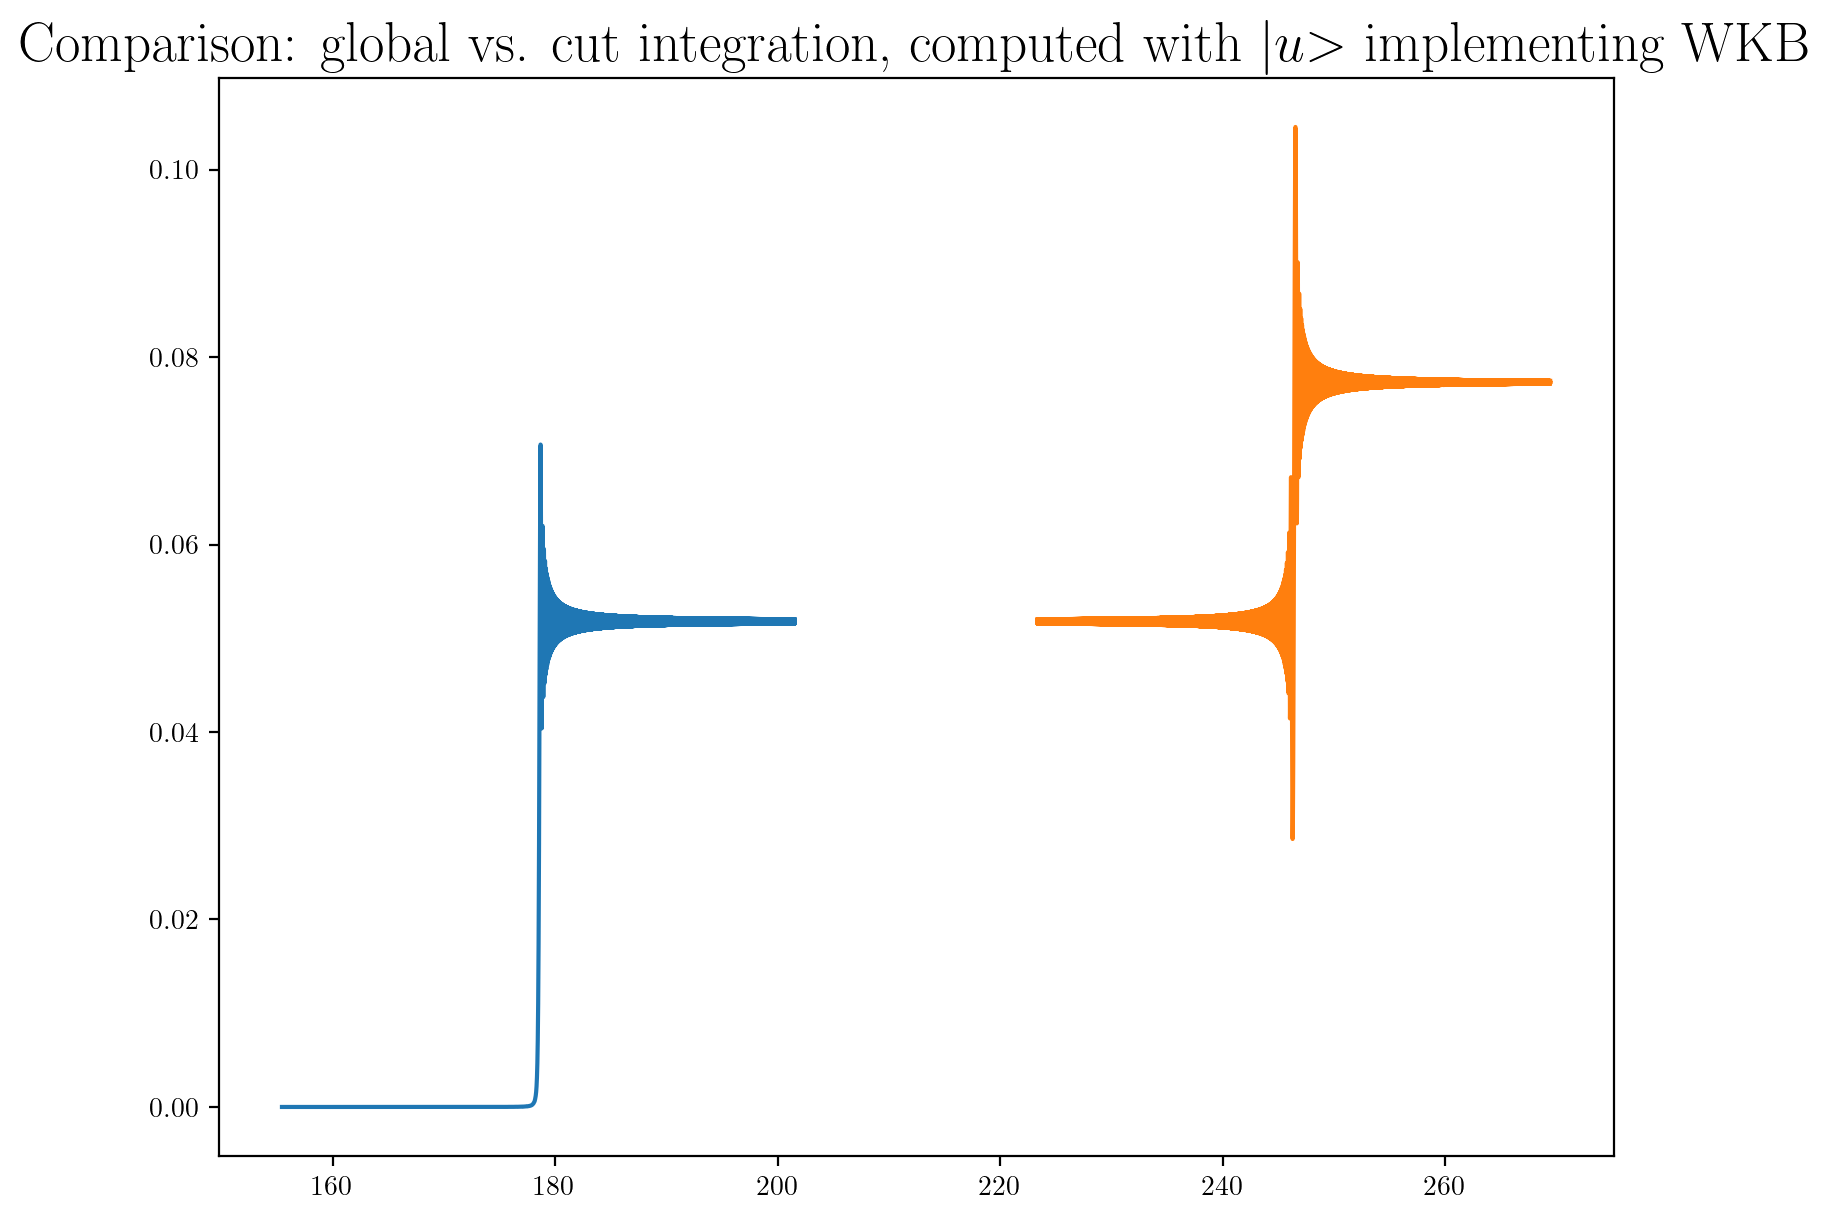

In [27]:
############################################################################
# Plotting global vs cut integration for |u⟩
############################################################################

for i in range(0,len(z_tilde_thr_cut_list)):
    plt.plot(z_tilde_thr_cut_list[i], np.abs(sol_u_intervals[i].y[0])**2)
    
plt.title('Comparison: global vs. cut integration, computed with $|u⟩$ implementing WKB', fontsize=20)


In [28]:
end = time.time()
print(f"Total time: {end - start:.2f} seconds")

Total time: 49.58 seconds
